In [31]:
import pandas as pd
import nilmtk
import matplotlib.pyplot as plt
import random
import sys
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import h5py
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.datastore import HDFDataStore
from matplotlib import rcParams
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
import tensorflow as tf
from tensorflow import keras
from Lstm import RNNDisaggregator
import time
import metrics

In [32]:
print("========== OPEN DATASETS ============")
train_house02 = DataSet('/root/autodl-tmp/redd_low_new.h5')
train_house03 = DataSet('/root/autodl-tmp/redd_low_new.h5')
train_house02.set_window(end="5-2-2011")
train_house03.set_window(end="28-4-2011")

val = DataSet('/root/autodl-tmp/redd_low_new.h5')
val.set_window(start="16-5-2011")

test = DataSet('/root/autodl-tmp/redd_low_new.h5')
test.set_window(end="5-3-2011")

train_building = [2,3]
val_building = 1
test_building = 1
sample_period = 3
meter_key = 'fridge'

train_mains = []
train_mains.append(train_house02.buildings[train_building[0]].elec.mains().all_meters()[1])
train_mains.append(train_house03.buildings[train_building[1]].elec.mains().all_meters()[0])
# train_mains.append(train.buildings[train_building[2]].elec.mains().all_meters()[0])

train_meters = []
train_meters.append(train_house02.buildings[train_building[0]].elec.submeters()[meter_key])
train_meters.append(train_house03.buildings[train_building[1]].elec.submeters()[meter_key])


test_mains = test.buildings[test_building].elec.mains().all_meters()[0]
test_meters = test.buildings[test_building].elec.submeters()[meter_key]

val_mains = val.buildings[val_building].elec.mains().all_meters()[0]
val_meters = val.buildings[val_building].elec.submeters()[meter_key]


rnn = RNNDisaggregator(window_size=600)

========== OPEN DATASETS ============
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 600, 16)           80        
_________________________________________________________________
bidirectional_6 (Bidirection (None, 600, 256)          148480    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,264,977
Trainable params: 1,264,977
Non-trainable params: 0
______

In [33]:
start = time.time()
print("========== TRAIN ============")

history01 = rnn.train(train_mains[0], train_meters[0], epochs=30,sample_period=sample_period)
# history02 = rnn.train(train_mains[1], train_meters[1], epochs=10,sample_period=sample_period)
rnn.export_model("model_CNNLSTM_Fridge-win600.h5")

end = time.time()
print("Train =", end-start, "seconds.")

========== TRAIN ============
(399661, 600, 1)
(399661,)
356.2344
84.37994
219.84592
61.480576
256
Epoch 1/30
1406/1406 [==============================] - 205s 143ms/step - loss: 0.6431 - val_loss: 0.5441
Epoch 2/30
1406/1406 [==============================] - 202s 143ms/step - loss: 0.4047 - val_loss: 0.4795
Epoch 3/30
1406/1406 [==============================] - 201s 143ms/step - loss: 0.3874 - val_loss: 0.4519
Epoch 4/30
1406/1406 [==============================] - 201s 143ms/step - loss: 0.3781 - val_loss: 0.4362
Epoch 5/30
1406/1406 [==============================] - 201s 143ms/step - loss: 0.3715 - val_loss: 0.4250
Epoch 6/30
1406/1406 [==============================] - 200s 143ms/step - loss: 0.3657 - val_loss: 0.4170
Epoch 7/30
1406/1406 [==============================] - 201s 143ms/step - loss: 0.3603 - val_loss: 0.4082
Epoch 8/30
1406/1406 [==============================] - 201s 143ms/step - loss: 0.3547 - val_loss: 0.4000
Epoch 9/30
1406/1406 [==============================]

In [34]:
print("========== DISAGGREGATE ============")
disag_filename = 'disag_CNNLSTM_Fridge-win600'
output = HDFDataStore(disag_filename, 'w')
rnn.disaggregate(test_mains, output, train_meters[0], sample_period=sample_period)
output.close()

========== DISAGGREGATE ============
New sensible chunk: 5533
New sensible chunk: 26611
New sensible chunk: 7822
New sensible chunk: 6689
New sensible chunk: 653
New sensible chunk: 29766
New sensible chunk: 13757
New sensible chunk: 32510
New sensible chunk: 34806
New sensible chunk: 20284
New sensible chunk: 64862
New sensible chunk: 31931
New sensible chunk: 41483
New sensible chunk: 37554
New sensible chunk: 8252


========== Plot ============


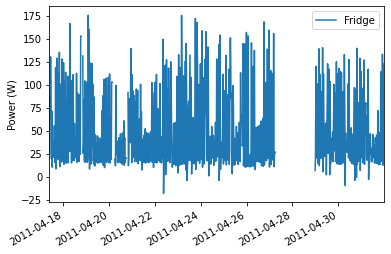

In [35]:
result = DataSet(disag_filename)
res_elec = result.buildings[test_building].elec

print("========== Plot ============")

predicted = res_elec[meter_key]
ground_truth = test_meters
import matplotlib.pyplot as plt
predicted.plot()
# ground_truth.plot()
# ground_truth.plot(timeframe=good_sections_pre[2])
# ground_truth.plot(timeframe=good_sections_pre[0])
plt.show()

In [36]:
good_sections_pre = predicted.good_sections()
good_sections_pre

[TimeFrame(start='2011-04-18 09:52:06-04:00', end='2011-04-18 13:58:45-04:00', empty=False),
 TimeFrame(start='2011-04-18 14:33:03-04:00', end='2011-04-19 12:13:36-04:00', empty=False),
 TimeFrame(start='2011-04-19 12:44:12-04:00', end='2011-04-19 18:45:18-04:00', empty=False),
 TimeFrame(start='2011-04-19 20:50:03-04:00', end='2011-04-20 01:54:30-04:00', empty=False),
 TimeFrame(start='2011-04-20 02:25:33-04:00', end='2011-04-20 02:28:12-04:00', empty=False),
 TimeFrame(start='2011-04-20 02:58:48-04:00', end='2011-04-21 03:17:06-04:00', empty=False),
 TimeFrame(start='2011-04-21 06:47:12-04:00', end='2011-04-21 17:45:03-04:00', empty=False),
 TimeFrame(start='2011-04-21 20:11:24-04:00', end='2011-04-22 22:46:54-04:00', empty=False),
 TimeFrame(start='2011-04-22 23:18:30-04:00', end='2011-04-24 03:48:48-04:00', empty=False),
 TimeFrame(start='2011-04-24 04:22:21-04:00', end='2011-04-24 20:46:33-04:00', empty=False),
 TimeFrame(start='2011-04-24 21:17:12-04:00', end='2011-04-27 02:50:18

In [37]:
ground_truth

ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])

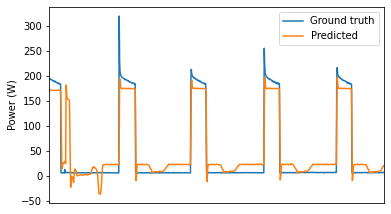

In [38]:
ground_truth.plot(timeframe=good_sections_pre[3])
predicted.plot(timeframe=good_sections_pre[3])
plt.legend(['Ground truth', 'Predicted'])
plt.show()

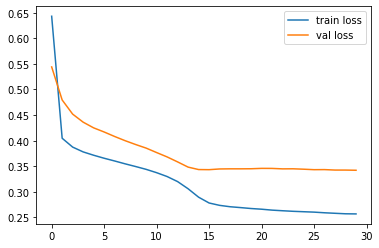

In [39]:
plt.plot(history01['loss'],label='train loss')
plt.plot(history01['val_loss'], label='val loss')
plt.legend()


In [40]:
print("========== RESULTS ============")
result = DataSet(disag_filename)
res_elec = result.buildings[test_building].elec
rpaf = metrics.recall_precision_accuracy_f1(res_elec[meter_key], test_meters)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(res_elec[meter_key], test_meters)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(res_elec[meter_key], test_meters)))

========== RESULTS ============
============ Recall: 0.9155856978462334
============ Precision: 0.45015132037066796
============ Accuracy: 0.5003337915895835
============ F1 Score: 0.6035599903941754
============ Relative error in total energy: 0.1325871023739434
============ Mean absolute error(in Watts): 34.69506453101076
